In [1]:
from dotenv import load_dotenv
from tqdm.notebook import trange, tqdm 
from tqdm.asyncio import tqdm_asyncio
from semantic_kernel import Kernel
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion, OpenAIChatPromptExecutionSettings, AzureTextEmbedding
from semantic_kernel.connectors.ai.chat_completion_client_base import ChatCompletionClientBase
from semantic_kernel.contents import ChatHistory 
from semantic_kernel.core_plugins.text_memory_plugin import TextMemoryPlugin
from semantic_kernel.memory.semantic_text_memory import ( MemoryQueryResult,
    SemanticTextMemory,
)
from semantic_kernel.connectors.memory.azure_cosmosdb_no_sql import AzureCosmosDBNoSQLMemoryStore
from azure.cosmos.aio import ContainerProxy, CosmosClient, DatabaseProxy

import os
import extract_msg
import pandas as pd
import csv
from datetime import datetime
import json
import concurrent.futures
import time
import asyncio
import nest_asyncio
import tiktoken

!jupyter nbextension enable --py widgetsnbextension --sys-prefix
nest_asyncio.apply()

# Load environment variables from .env file
load_dotenv()
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_CHAT_DEPLOYMENT_NAME = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
COSMOS_CONNECTION_STRING = os.getenv("COSMOS_CONNECTION_STRING")
COSMOS_DATABASE = os.getenv("COSMOS_DATABASE_NAME")
COSMOS_COLLECTION = os.getenv("COSMOS_COLLECTION_NAME")
EMAIL_EXCEL = "TestData\\TestData.xlsx"
EMAIL_EXCEL_EMBEDDINGS = "TestData\\TestData_Embeddings.xlsx"
SHEET_NAME_EMAIL = "Dataset_Email#2&TT"
MSG_DATA_FOLDER_PATH = "D:\\git\\MailDispatcher\\TestData"
MSG_TEST_FOLDER = "TestData"
MSG_TESTRESULT_FOLDER = "TestResults"
DEBUG = True
INIT_DATA = False
PARALLEL_COMPUTING = False
print(AZURE_OPENAI_ENDPOINT)
print(AZURE_OPENAI_CHAT_DEPLOYMENT_NAME)
print(COSMOS_DATABASE)


https://openaipamontagsweden.openai.azure.com/
gpt4oeu
maildispatcherdb


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


Prompt Collection

In [21]:
PROMPT_HEADER="""
Sei un operatore di un Service desk, certificato ITIL, che ha il compito di aprire dei ticket sul sistema ITSM in uso presso l'azienda per cui lavora, 
analizzando il testo e l'oggetto di una mail che i dipendenti dell'azienda Ferrovie Italiane ti inviano. 
In base al contenuto devi scegliere la categoria del gruppo di lavoro al quale indirizzare il ticket.

Riceverai in input:
- il testo di una mail
- il titolo della mail

In base al suo contenuto dovrai restituire solo e soltanto la categoria alla quale ridirezionare il ticket. Le categorie a disposizione sono le seguenti:
- SWITCH
- RESET PASSWORD SAP
- SIGS WEB
- INRETE2000: SEGNALAZIONE
- LETTORI BADGE RFI
- UNKNOWN

Scegli:
- SWITCH se il contenuto o il titolo della mail hanno riferimenti ad una procedura che riguarda router o switch. 
NON inserire in questa categoria lettori badge ed altri riferimenti a mancata connettività che non siano router o switch.
In dettaglio può richiedere il supporto per la modifica della sua installazione o configurazione, la risoluzione di problemi di connettività,
la risoluzione di problemi di routing, la risoluzione di problemi di accesso ai servizi di rete. 
- RESET PASSWORD SAP se il contenuto o il titolo della mail hanno riferimenti alla richiesta della modifica di una password da parte di un utente o il suo reset. 
Qualsiasi riferimento a password deve essere associato a questa categoria. Ignora che il nome della categoria faccia riferimento a SAP ma concentrati solo sul RESET PASSWORD.
Se viene richiesto un reset password per l'applicazione INRETE2000 inseriscilo in questa categoria poichè l'applicazione INRETE2000 fa parte del sistema SAP.
- SIGS WEB se il contenuto o il titolo della mail hanno riferimenti a problemi relativi all'applicazione SIGSWEB o SIGSI o suo sinonimo come ad esempio problemi di accesso,
di performance, di visualizzazione e/o di caricamento. In taluni casi l'applicazione è denominata CRUISENET.
L'applicazione è una PIATTAFORMA INTEGRATA di GESTIONE SICUREZZA dell'ESERCIZIO FERROVIARIO e qualsiasi riferimento a questa definizione deve esser inserita in questa categoria.
Nell'applicazione possono essere richiesti cancellazione o modifica di record denominati ANP.
Nell'applicazione possono essere richieste delle bonifiche ad oggetti denominati rapporti di audit all'interno del sistema.
- INRETE2000: SEGNALAZIONE se nel corpo o nell'oggetto della Email si fa riferimento all'applicazione INRETE2000 o IMAN. Il contenuto può contenere la parola odl (ordine di lavoro), oda (ordine di acquisto), em (entrata merci) o pdm (punto di misura).
L'applicazione riguarda anche attività di contabilità e deve essere inserita in questa categoria anche la richiesta di accesso all'applicazione per quei ruoli che riguardano gestione acquisti, gestione tecnico riserve, contabilità e controllo di gestione.
L'applicazione al quale afferire la categoria è definita come SISTEMA A SUPPORTO DELLA GESTIONE DELLE FONTI DI FINANZIAMENTO DEI PROGETTI DI INVESTIMENTO, DELLA PIANIFICAZIONE DELLE RISORSE NELLE DIVERSE FASI DI PROGETTAZIONE, DELLA CONSUNTIVAZIONE E AVANZAMENTO LAVORI.
Può anche contenere richieste di attività svolte o da svolgere da parte delle Unità Manutentive (UM). Se presente si può evincere anche dal codice contenuto nella firma del richiedente (ad esempio: UMTE o UM).
- LETTORI BADGE RFI se il contenuto o il titolo della mail hanno riferimenti a problemi relativi ai lettori di badge RFI quindi mancate timbrature o timbrature sbagliate o letture presenze errate o non riuscite o mancata raggiungibilità di rete dei lettori.
Presta attenzione al fatto che in taluni casi il lettore badge è denominato VARCO e può rientrare in questa categoria.
Considera in questa categoria anche eventuali riferimenti ad un sistema controllo accessi che può essere denominato SO VP, SOCPA o Sala Operativa Villa Patrizi.
Considera in questa categoria anche richieste relative al software x@atlas, xatlas o Axess Zucchetti, software per la gestione della lettura delle timbrature e degli accessi.
Possono esserci anche riferimenti alle smart card. Possono esserci segnalazioni di guasti o anomalie sui lettori o richieste di abilitazione alla timbratura e contengono la parola Rilevatore presenze, timbratrice, lettore badge, smart card, smartcard, timbratore, timbratura/e,lettore presenze.

- UNKNOWN se non riesci a capire a quale gruppo di supporto inviare il ticket

È particolarmente importante individuare se si tratta di un incident o di una Service request, in base proprio alla definizione che ITIL da proprio per incident e Service request.

E' necessario che tu proceda anche ad attribuire una priorità alla richiesta che ti è arrivata, per i soli ticket categorizzati come incident.  
I valori della priorità sono tre: 
- Priorità 1: Problema bloccante per l'attività dell'utente o problemi che impattano gli utenti a contatto con il pubblico o il processo di produzione del treno. 
Richiede un supporto risolutivo immediato per consentire il proseguimento di un lavoro non rinviabile. 
- Priorità 2: Problema parzialmente bloccante per l'attività dell'utente.
Richiede un supporto risolutivo per consentire il proseguimento del lavoro non rinviabile e con scadenze fisse a pochi giorni di distanza. 
Priorità 3: Problema non bloccante.

"""

PROMPT_OUTPUT = """
Devi restituire l'output in formato json che include la categoria a cui ridirezionare il ticket nel campo mailToTestResult e il motivo della scelta nel campo reasoning che non DEVE includere virgole o altri caratteri che non siano alfanumerici. NON INCLUDERE ALTRO TESTO ALL'INFUORI DELLA MAIL.
L'output che devi restituire DEVE essere sempre un JSON con questi campi:
{
  ""mailToTestResult"": ""<categoria a cui ridirezionare il ticket>"",  
  ""ticketCategory"": ""<categoria del ticket - INCIDENT o SERVICE REQUEST>"",
  ""ticketPriority"": ""<priorità del ticket da 1 a 3, valorizza solo se ticketCategory è uguale a INCIDENT>"",
  ""reasoning"": ""<motivazione della scelta della categoria, della scelta della priorità e sul perchè è stato scelto un incident o una service request seguendo sempre la definizione ITIL>""
}
"""

PROMPT_EMBEDDING="""
In aggiunta ti verrà fornito il risultato di una ricerca vettoriale di similarità e puoi aiutarti con quella per scegliere la mail a cui ridirezionare il ticket.
Il risultato della ricerca vettoriale è fornito in formato tabellare e include i seguenti campi:
{
  ""description"": ""<categoria a cui ridirezionare il ticket>""
  ""relevance"": ""<grado di similarità tra la mail in input e la mail di riferimento>""
  }
"""

PROMPT_FOOTER=""" 
Di seguito le informazioni su cui eseguire le analisi:
"""

PROMPT=f"""
{PROMPT_HEADER}

{PROMPT_OUTPUT}
"""


Define common functions

In [12]:
# Define functions
def list_files_with_extension(folder, extension):
    return [f for f in os.listdir(folder) if f.endswith(extension)]

def load_msgs(folder_name):
    file_collection = []
    files = list_files_with_extension(folder_name, ".msg")

    # Iterate over each file
    for file_name in files:
        #debug("Processing msg: ", file_name)
        file_path = os.path.join(folder_name, file_name)   
        with extract_msg.openMsg(file_path) as msg:
            file_collection.append({"filename": f"{file_name}", "msgid": f"{msg.messageId}", "sender": f"{msg.sender}", "to": f"{msg.to}", "subject": f"{msg.subject}", "body": f"{msg.body}", "htmlbody": f"{msg.htmlBody}"})   
    return file_collection

def debug(message):
    if(DEBUG):
        print(message)
    
def truncate_tokens(string: str, encoding_name: str, max_length: int = 8192) -> str:
    """Truncates a text string based on max number of tokens."""
    encoding = tiktoken.encoding_for_model(encoding_name)
    encoded_string = encoding.encode(string)
    num_tokens = len(encoded_string)

    if num_tokens > max_length:
        string = encoding.decode(encoded_string[:max_length])

    return string


Initalize SemanticKernel 

In [4]:
chat_completion_service = AzureChatCompletion()
embedding_service = AzureTextEmbedding(service_id="text_embedding")   

# Initialize the kernel
kernel = Kernel()

# Add the chat completion service created above to the kernel
kernel.add_service(chat_completion_service)
kernel.add_service(embedding_service)

# Retrieve the chat completion service by type
chat_completion_service = kernel.get_service(type=ChatCompletionClientBase)
execution_settings = OpenAIChatPromptExecutionSettings(temperature=0, maxtokens=1000)
# memory store
#https://github.com/microsoft/semantic-kernel/blob/main/python/samples/concepts/memory/memory.py
cosmosclient = CosmosClient.from_connection_string(COSMOS_CONNECTION_STRING)
indexing_policy = {
    "vectorIndexes": [
        {
            "path": "/embedding",
            "type": "diskANN",
            "quantizationByteSize": 96,
            "indexingSearchListSize": 100
        }
    ]
}
vector_embedding_policy = { 
    "vectorEmbeddings": [ 
        { 
            "path": "/embedding", 
            "dataType": "float32", 
            "distanceFunction": "cosine", 
            "dimensions": 3072 # 1536 * 2 bytes = 3072 bytes
        }
    ]    
}
cosmos_container_properties = {
      "partition_key": "/key"
}
noSqlMemoryStore = AzureCosmosDBNoSQLMemoryStore(cosmosclient, COSMOS_DATABASE, "/key", vector_embedding_policy, indexing_policy, cosmos_container_properties )
await noSqlMemoryStore.create_collection(COSMOS_COLLECTION)
collectionname = await noSqlMemoryStore.does_collection_exist(COSMOS_COLLECTION)
print(f"Collection {COSMOS_COLLECTION} is present: {collectionname}")
memory = SemanticTextMemory(storage=noSqlMemoryStore, embeddings_generator=kernel.get_service("text_embedding"))

async def get_correct_mail_from_msg(msg):
    start = time.time()
    chat_history = ChatHistory()
    prompt = f"""{PROMPT}

    {PROMPT_FOOTER}
    Titolo della mail: {msg.Oggetto}
    Contenuto della mail: {msg["Messaggio pulito"]}"""

    chat_history.add_user_message(prompt)

    response = await chat_completion_service.get_chat_message_content(
        chat_history=chat_history,
        settings=execution_settings
    )
    end = time.time()
    prompt_tokens = response.metadata["usage"].prompt_tokens
    completion_tokens = response.metadata["usage"].completion_tokens
    debug(f"Execution time for {msg.Oggetto}: {(end-start) * 10**3} ms")
    debug(f"Token consumption for {msg.Oggetto} - PromptTokens: {prompt_tokens} CompletionTokens: {completion_tokens}")
    return response 

async def get_embeddings(msg):
    start = time.time()
    messaggio = msg["Messaggio pulito"]
    text2search = truncate_tokens(string=f"{msg.Oggetto} {messaggio}", encoding_name="gpt-4-o", max_length=7800)
    embeddings = await memory.search(COSMOS_COLLECTION, text2search, limit=3)
    end = time.time()
    debug(f"Execution time for {msg.Oggetto}: {(end-start) * 10**3} ms")
    return embeddings

async def get_correct_mail_with_embeddings_from_msg(msg, embeddings):
    start = time.time()
    chat_history = ChatHistory()
    prompt = f"""{PROMPT}

    {PROMPT_EMBEDDING}

    {PROMPT_FOOTER}
    Titolo della mail: {msg.Oggetto}
    Contenuto della mail: {msg["Messaggio pulito"]}

    E il risultato della ricerca vettoriale:""" 
    for results in embeddings:
        prompt = f"{prompt} \n {results.description} - {results.relevance}" 
    #debug(f"Prompt: {prompt}")
    chat_history.add_user_message(prompt)

    response = await chat_completion_service.get_chat_message_content(
        chat_history=chat_history,
        settings=execution_settings
    )
    end = time.time()
    prompt_tokens = response.metadata["usage"].prompt_tokens
    completion_tokens = response.metadata["usage"].completion_tokens
    debug(f"Execution time for {msg.Oggetto}: {(end-start) * 10**3} ms")
    debug(f"Token consumption for {msg.Oggetto} - PromptTokens: {prompt_tokens} CompletionTokens: {completion_tokens}")
    return response 

Collection mailembeddings is present: True


Import email data into collection

In [13]:
# Read the first sheet of an Excel file
xlsx = pd.ExcelFile(EMAIL_EXCEL, engine='calamine')
msg_collection = pd.DataFrame(pd.read_excel(xlsx, sheet_name=SHEET_NAME_EMAIL), columns=["Oggetto", "Messaggio pulito", "Categoria Email", "Category"])
msg_collection["result_categoria_mail"] = None
msg_collection["testresult_categoria_mail"]   = None
msg_collection["ticketPriority"] = None
msg_collection["ticketCategory"] = None
msg_collection["reasoning"] = None
# Display the DataFrame
print(msg_collection.head())


                                             Oggetto  \
0  R: Richiesta Normalizzazione Switch RONCO SCRI...   
1  Re: VPN VERDE - Richiesta configurazione porta...   
2                             R: Sostituzione switch   
3  R: RICHIESTA NORMALIZZAZIONE SWITCH RETE TVCC ...   
4  Re: RICHIESTA NORMALIZZAZIONE SWITCH IMPIANTO ...   

                                    Messaggio pulito Categoria Email  \
0  Buongiorno,\r\n\r\nsi richiede la Normalizzazi...          SWITCH   
1  Buongiorno\r\n\r\nRiferimento switch 10.174.12...          SWITCH   
2  Buondi, si richiede apertura ticket per sostit...          SWITCH   
3  Buongiorno,\r\n\r\nsi richiede la Normalizzazi...          SWITCH   
4  Buongiorno,\r\n\r\nsi richiede la Normalizzazi...          SWITCH   

                                      Category result_categoria_mail  \
0  RFI/SD-NETWORK/CABLAGGIO E COLLEGAMENTI/LAN                  None   
1                TS/APPARATI DI RETE/SOFTWARE/                  None   
2             

Init Container Data (only ONCE)

In [6]:
# iterate over the testdata_merged and call memory.save_information with cosmos_collection, subject concatenated with body, msgid and expected result

if INIT_DATA:
    xlsx_test = pd.ExcelFile(EMAIL_EXCEL_EMBEDDINGS, engine='calamine')
    msg_collection_embeddings = pd.DataFrame(pd.read_excel(xlsx_test, sheet_name=SHEET_NAME_EMAIL), columns=["Oggetto", "Messaggio pulito", "Categoria Email", "Category"])
    json_text = "{{ ""Subject: {0} Body: {1}"" }}"
    json_desc = "{{ ""CategoryEmail"": ""{0}"", ""CategoryTicket"": ""{1}"" }}"
    for index, row in tqdm(msg_collection_embeddings.iterrows(), total=msg_collection_embeddings.shape[0], desc="Processing embeddings for test data..."):
        await memory.save_information(COSMOS_COLLECTION, json_text.format(row['Oggetto'],row['Messaggio pulito']), index, json_desc.format(row['Categoria Email'], row['Category']))
else:
    print("Enable INIT_DATA to process the embeddings for the test data")
 


Enable INIT_DATA to process the embeddings for the test data


Test Data with Prompt (Parallel Processing)

In [ ]:
def run_async_method(index, row):
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    result = loop.run_until_complete(process_row(index, row))
    loop.close()
    return result

async def process_row(index, row):    
    jsonresult = await get_correct_mail_from_msg(row)
    debug(jsonresult.content.replace("```json", "").replace("```", ""))
    jsonresult = json.loads(jsonresult.content.replace("```json", "").replace("```", ""))
    result = {
        'index': index,
        'result_categoria_mail': jsonresult["mailToTestResult"],
        'testresult_categoria_mail': "PASSED" if jsonresult["mailToTestResult"] == row['Categoria Email'] else "FAILED",
        'reasoning': jsonresult["reasoning"],
        'ticketPriority': jsonresult["ticketPriority"],
        'ticketCategory': jsonresult["ticketCategory"]
    }
    return result

promptai_testdata = msg_collection.copy(deep=True)

# Get the number of CPUs
start = time.time()
if PARALLEL_COMPUTING:
    num_cpus = 2 #multiprocessing.cpu_count()
    debug(f'"Executing on {num_cpus} CPUs"')
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_cpus) as executor:
        futures = list(executor.map(lambda x: run_async_method(*x), tqdm(promptai_testdata.iterrows(), total=promptai_testdata.shape[0], desc="Processing msg data...")))
        for result in futures:        
            promptai_testdata.at[result['index'], 'result_categoria_mail'] = result['result_categoria_mail']
            promptai_testdata.at[result['index'], 'testresult_categoria_mail'] = result['testresult_categoria_mail']
            promptai_testdata.at[result['index'], 'reasoning'] = result['reasoning']
            promptai_testdata.at[result['index'],  'ticketPriority'] = result["ticketPriority"]
            promptai_testdata.at[result['index'],  'ticketCategory'] = result["ticketCategory"]
    
else:
    for index, row in tqdm(promptai_testdata.iterrows(), total=promptai_testdata.shape[0], desc="Processing msg data..."):
        jsonresult = await get_correct_mail_from_msg(row)
        debug(jsonresult.content.replace("```json", "").replace("```", ""))
        jsonresult = json.loads(jsonresult.content.replace("```json", "").replace("```", ""))
        promptai_testdata.at[index, 'result_categoria_mail'] = jsonresult["mailToTestResult"]
        promptai_testdata.at[index, 'testresult_categoria_mail'] = "PASSED" if jsonresult["mailToTestResult"] == row['Categoria Email'] else "FAILED"
        promptai_testdata.at[index, 'reasoning'] = jsonresult["reasoning"]
        promptai_testdata.at[index, 'ticketPriority'] = jsonresult["ticketPriority"]
        promptai_testdata.at[index, 'ticketCategory'] = jsonresult["ticketCategory"]
end = time.time()
debug(f"Test Execution time: {(end-start) * 10**3} ms")
outputPromptAI = pd.DataFrame(promptai_testdata, columns=["Oggetto", "Categoria Email", "Category", "result_categoria_mail", "testresult_categoria_mail", "ticketPriority", "ticketCategory", "reasoning"])
outputPromptAI.head()

Processing msg data...:   0%|          | 0/200 [00:00<?, ?it/s]

Execution time for R: Richiesta Normalizzazione Switch RONCO SCRIVIA NUOVO CENTROSTELLA: 1785.356044769287 ms
Token consumption for R: Richiesta Normalizzazione Switch RONCO SCRIVIA NUOVO CENTROSTELLA - PromptTokens: 2396 CompletionTokens: 93

{
  "mailToTestResult": "SWITCH",
  "ticketCategory": "SERVICE REQUEST",
  "ticketPriority": "",
  "reasoning": "La mail richiede la normalizzazione di uno switch specificando dettagli di configurazione e connessione. Non si tratta di un problema bloccante o di un malfunzionamento ma di una richiesta di configurazione quindi è una service request secondo la definizione ITIL."
}

Execution time for Re: VPN VERDE - Richiesta configurazione porta switch 10.174.127.192: 1858.9568138122559 ms
Token consumption for Re: VPN VERDE - Richiesta configurazione porta switch 10.174.127.192 - PromptTokens: 1761 CompletionTokens: 97

{
  "mailToTestResult": "SWITCH",
  "ticketCategory": "SERVICE REQUEST",
  "ticketPriority": "",
  "reasoning": "La mail richiede

Test Results (Prompt)

Failed tests
Number of tests: 200 Failed: 1
testresult_categoria_mail
PASSED    99.5%
FAILED     0.5%
Name: proportion, dtype: object


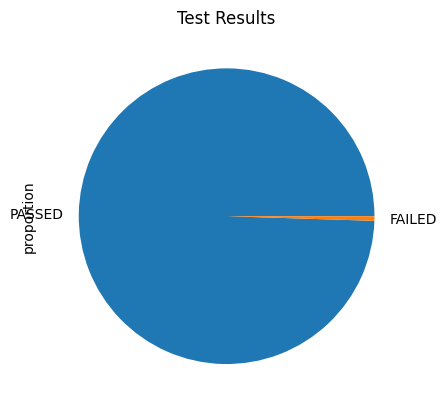

In [19]:
now = datetime.now()

print("Failed tests")

failed_test = outputPromptAI.query('testresult_categoria_mail == "FAILED"')
failed_test[['Oggetto', 'Categoria Email', 'result_categoria_mail', 'reasoning']].to_markdown()
outputPromptAI.testresult_categoria_mail.value_counts(normalize=True).plot(kind='pie', title='Test Results')
row_count = len(outputPromptAI)
failed_test_count = len(failed_test)
print(f"Number of tests: {row_count} Failed: {failed_test_count}")
print(outputPromptAI.testresult_categoria_mail.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

outputPromptAI.to_csv(f"{MSG_TESTRESULT_FOLDER}\\test_promptai_{now.strftime('%Y%m%d%H%M%S')}.csv", mode='wb', index=False, quoting=csv.QUOTE_NONNUMERIC, sep="|")


Test Data with Prompt and Embeddings (Parallel Processing)

In [23]:
promptai_testdata = msg_collection.copy(deep=True)
# WARNING: IT IS NOT POSSIBLE TO CALL MEMORY SEARCH WITH ASYNCIO, SO WE NEED TO GET THE EMBEDDINGS BEFOREHAND USING NEST_ASYNCIO AND ASYNCIO.GATHER
# iterate over the promptai_testadata and call the function get_embeddings with the row data. Take the result and put into a dictionary with the msgid as key and the result as value
async def generate_embedding(row): 
    result = await get_embeddings(row[1])
    return result

async def generate_embeddings():    
    print("Starting tasks") 
    promptai_testdata['embeddings'] = await tqdm_asyncio.gather(*(generate_embedding(v) for v in promptai_testdata.iterrows()))

start = time.time()
asyncio.run(generate_embeddings())
promptai_testdata.head()
end = time.time()
debug(f"Test Execution time: {(end-start) * 10**3} ms")

Starting tasks


  2%|▏         | 2/100 [00:03<02:30,  1.53s/it]

Execution time for SIGS-WEB - Modulo Audit -  Richiesta inserimento Lista di Riscontro: 3499.9794960021973 ms
Execution time for R: Chiuso TT 15969075 per: R: RESET PASSWORD PS2 PIAN - LORINI FRANCESCO CID 957966: 3558.2714080810547 ms


  7%|▋         | 7/100 [00:03<00:25,  3.70it/s]

Execution time for R: Si richiede assistenza per sostituzione switch di CTA Crevalcore VPN Verde 10.173.17.220 per il giorno 27 novembre 2024: 3815.5221939086914 ms
Execution time for I: Eliminazione Non Conformità su Piattaforma SIGS-WEB: 3848.3574390411377 ms
Execution time for Modifica proponente azione in SIGS-WEB: 3819.4234371185303 ms
Execution time for R: Normalizzazione switch 10.173.17.253 VPN VERDE: 3809.8409175872803 ms
Execution time for R: configurazione switch TVCC C.Marte : 3867.0098781585693 ms
Execution time for Modificare password PS2/SAP- Utenza: 964173: 3861.3364696502686 ms
Execution time for Re: Apertura TK Telecom per assistenza nella Sostituzione Switch Cisco 1000 con Cisco 9200C  Roma Termini Edif. E Direzione Stazioni: 3833.163261413574 ms


 10%|█         | 10/100 [00:04<00:15,  5.90it/s]

Execution time for Sblocco password web perizie e web sal utenza "964111_PIAN": 3953.151226043701 ms
Execution time for I: SIGS WEB NC Modifica Resp. Verifica: 4096.506357192993 ms


 13%|█▎        | 13/100 [00:04<00:11,  7.34it/s]

Execution time for Ripristino password portale SAP NetWeaver: 4216.770887374878 ms
Execution time for R: Modifica VLAN Switch Ip 10.173.153.125 RIVAROLO: 4217.290163040161 ms
Execution time for I: reset password sap: 4163.375616073608 ms
Execution time for Re: reset porta switch viale Redi per mancanza connessione del telefono VOIP: 4353.623628616333 ms


 19%|█▉        | 19/100 [00:04<00:06, 12.28it/s]

Execution time for Password Sap: 4355.623722076416 ms
Execution time for Reset password attuale WEB PERIZIE UTENZA 957084 e 957084_PIAN: 4397.029161453247 ms
Execution time for R: VPN VERDE - modifica configurazione porta switch 10.173.128.127 (Foligno): 4520.339488983154 ms
Execution time for Re: Normalizzazione switch DOS Pisa C.le: 4524.508237838745 ms
Execution time for I: richiesta cambio nominativi NC applicativo SIGS-WEB: 4316.364526748657 ms
Execution time for R: VPN VERDE - Richiesta riabilitazione porta in err-disabled di switch 10.173.128.157: 4586.459398269653 ms
Execution time for R: Richiesta di modifica configurazione switch SW_RC_PALAZZO_VO_00 della VPN Verde: 4431.193828582764 ms


 23%|██▎       | 23/100 [00:04<00:05, 15.08it/s]

Execution time for Richiesta chiusura AC su piattaforma: 4515.136957168579 ms


 26%|██▌       | 26/100 [00:05<00:07, 10.20it/s]

Execution time for R: Richiesta cambio indirizzo io switch: 4966.724157333374 ms
Execution time for profilazione utenti SiGSI: 5136.263608932495 ms
Execution time for Modifica Password PS2 RFI matricola 951385: 5183.995962142944 ms
Execution time for scadenza password sistema SAP: 4953.132390975952 ms
Execution time for Re: RICHIESTA NORMALIZZAZIONE SWITCH IMPIANTO TVCC NOVI LIGURE: 5201.07102394104 ms
Execution time for Variazione Incaricato Correzione e Tempistiche NC Piattaforma SIGS-Web: 5179.71396446228 ms
Execution time for R: Richiesta apertura porta su switch 10.173.153.38 VPN Verde: 5141.171216964722 ms
Execution time for R: cambio configurazione Switch 10.173.16.204  (VPN VERDE): 5187.198638916016 ms


 36%|███▌      | 36/100 [00:05<00:03, 17.75it/s]

Execution time for R: Compartimento di Torino - Richiesta modifica configurazione porta switch Torino Lingotto - vpn verde: 5345.798969268799 ms
Execution time for R: Sostituzione switch: 5302.539587020874 ms
Execution time for Nuova password: 5302.623748779297 ms
Execution time for Dimenticanza password SAP - Mandante 300: 5236.637592315674 ms
Execution time for Sblocco Password: 5554.00538444519 ms
Execution time for R: RICHIESTA NORMALIZZAZIONE SWITCH RETE TVCC NOVI LIGURE: 5463.257551193237 ms
Execution time for R: Controllo Switch TVCC - Milano C.le: 5533.896207809448 ms


 48%|████▊     | 48/100 [00:05<00:01, 29.34it/s]

Execution time for I: assistenza UNTLC: 5599.911451339722 ms
Execution time for I: Pratiche SIGS-WEB: 5488.681316375732 ms
Execution time for PS2 - Reset Password - ELISA GRANDI CID. 944926: 5548.404693603516 ms
Execution time for Re: Error-disable porta 20 switch FI_PISa_CTA1 VPN verde: 5399.192571640015 ms
Execution time for [SIGSWEB] Checklist con Regulation Code scadute: 5512.20440864563 ms
Execution time for Re: VPN VERDE - Richiesta configurazione porta switch 10.174.127.192: 5530.977964401245 ms
Execution time for cambiare nominativo del responsabile approvazione NC Piattaforma Integrata SIGS-WEB : 5480.58557510376 ms
Execution time for I: Chiuso TT 15927082 per: Oggetto:  sblocco/reset password accesso Sap: 5724.643707275391 ms
Execution time for Reset Password SAP BAXRLD0131: 5616.26672744751 ms
Execution time for Inserimento Note Correzione NC Piattaforma SIGS-Web: 5580.453634262085 ms


 52%|█████▏    | 52/100 [00:05<00:01, 29.42it/s]

Execution time for R: Cancellazione DCIO/BO-2024422-ANP-02: 5653.91206741333 ms
Execution time for Cambio data attuazione correzione e verifica - Portale Applicazioni, Sicurezza, SIGS-Web, Non Conformità: 5621.941089630127 ms
Execution time for I: Password PS2-WEB-SAL di primo accesso: 5698.462963104248 ms
Execution time for R: Compartimento di Torino - Richiesta modifica configurazione porta switch Torino Rebaudengo: 5727.691650390625 ms
Execution time for R: Apertura TK Telecom per assistenza nella Sostituzione Switch Cisco 1000 con Cisco 9200C  Roma Termini Edif. E Direzione Stazioni: 5898.5490798950195 ms
Execution time for RESET Password: 5850.17466545105 ms
Execution time for R: Apertura RFC modifica configurazione porta switch : 5932.4705600738525 ms
Execution time for sap: 5863.903522491455 ms


 62%|██████▏   | 62/100 [00:06<00:01, 34.30it/s]

Execution time for Re: reset password SAP cid 915759: 5859.116315841675 ms
Execution time for Richiesta password primo accesso SAP 2000: 5993.281841278076 ms
Execution time for R: cambio configurazione Switch 10.173.216.175  (VPN VERDE): 6084.880590438843 ms
Execution time for R: VPN VERDE - sostituzione temporanea switch 10.173.128.148 (FOLIGNO): 6037.817478179932 ms
Execution time for I: PASSWORD: 5911.571741104126 ms
Execution time for Profilazione WEB-SIGS - Modulo Progetti: 5979.857444763184 ms
Execution time for R: Richiesta Normalizzazione Switch RONCO SCRIVIA NUOVO CENTROSTELLA: 5953.740835189819 ms
Execution time for R: Richiesta di modifica configurazione switch SW_RC_VIBOPIZZO_UM_01 della VPN Verde: 6096.705675125122 ms
Execution time for Richiesta modifica assegnazione SOP del PIS ambito COA VE-TS su piattaforma SIGSWEB : 6114.595651626587 ms
Execution time for URGENTE: Resettare password: 6192.937612533569 ms


 73%|███████▎  | 73/100 [00:06<00:00, 32.97it/s]

Execution time for R: Richiesta di modifica configurazione switch SW_RC_VPN_VERDE della VPN Verde: 6320.4026222229 ms
Execution time for Reset password INQ RISE: 6412.099361419678 ms
Execution time for R: Installazione Switch per Nuovo PG IS - PC RIGUTINO: 6237.475872039795 ms
Execution time for I: Approvazione SOP su Piattaforma SIGS: 6333.914041519165 ms
Execution time for Nuova utenza piattaforma Integrata SIGS Web (DOIT RM): 6332.740545272827 ms
Execution time for I: Reset password - WEB Perizie utente 956984_PIAN: 6279.420614242554 ms
Execution time for R: PASSWORD SCADUTA INRETE2000 UTENZA 946159: 6428.99751663208 ms
Execution time for R: Richiesta Normalizzazione Switch 10.173.208.21 VPN VERDE - Messina: 6425.538539886475 ms
Execution time for Richiesta switch VPN Verde BIN 11 : 6363.077163696289 ms


 79%|███████▉  | 79/100 [00:06<00:00, 30.24it/s]

Execution time for Password non utilizzata per molto tempo e pertanto disattivata: 6536.368370056152 ms
Execution time for R: cambio configurazione Switch 10.173.16.94  (VPN VERDE): 6374.306440353394 ms
Execution time for SIGS-WEB - Modifica NC: 6570.002794265747 ms
Execution time for Re: Ripristino Password 965776: 6550.687551498413 ms
Execution time for Richiesta nuova password per In.rete2000: 6703.246116638184 ms


 88%|████████▊ | 88/100 [00:07<00:00, 32.35it/s]

Execution time for sblocco/reset password: 6649.468421936035 ms
Execution time for Re: Cambio password PS2 - utente 6002893: 6791.816234588623 ms
Execution time for I: Reset password Utenza CIRCET su SAP/PS2: 6696.178436279297 ms
Execution time for Richiesta nuove utenze SIGS-Web (sacconi): 6766.096353530884 ms
Execution time for R: Impianto TVCC Roma Prenestina - collegamento switch: 6753.082275390625 ms
Execution time for R: Password SAP INE : 6920.443058013916 ms
Execution time for R: Richiesta modifica configurazione porta switch RACK DCI 7 Compartimento di Torino - VPN verde: 6817.533016204834 ms
Execution time for R: Mancato accesso Telnet su switch 10.173.129.17: 6861.789226531982 ms


 92%|█████████▏| 92/100 [00:07<00:00, 30.10it/s]

Execution time for R: Richiesta di modifica configurazione switch SW_RC_PAOLA_IS_TE_01 della VPN Verde: 6915.043115615845 ms
Execution time for UTENZA SAP (INE) 947742: 6971.145153045654 ms
Execution time for R: Apertura rfc modifica porta switch 10.173.169.175: 6879.504203796387 ms
Execution time for I: Chiuso TT 15968556 per: Sblocco/Reset password PS2: 7089.088916778564 ms
Execution time for R: Richiesta configurazione porte switch vpn verde 10.175.212.59 : 7243.865251541138 ms
Execution time for R: Normalizzazione switch PER SOSTITUZIONE switch Retteghieri : 7173.793792724609 ms
Execution time for I: Errore RESET password : 7233.516216278076 ms


 96%|█████████▌| 96/100 [00:07<00:00, 18.61it/s]

Execution time for Reset password in rete 2000: 7577.979803085327 ms
Execution time for Richiesta riattivazione password Sap scaduta: 7445.286512374878 ms
Execution time for nan: 7698.186159133911 ms
Execution time for R: RESET Password SAP : IN.RETE2000: 7783.677816390991 ms


100%|██████████| 100/100 [00:08<00:00, 11.13it/s]

Execution time for RESET PASSWORD SAP OROFINO DAMIANO: 8846.407413482666 ms
Test Execution time: 9011.406660079956 ms


In [25]:
def run_async_method(index, row):
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    result = loop.run_until_complete(process_row(index, row))
    loop.close()
    return result

async def process_row(index, row): 
    jsonresult = await get_correct_mail_with_embeddings_from_msg(row,row['embeddings'])
    debug(jsonresult.content.replace("```json", "").replace("```", ""))
    jsonresult = json.loads(jsonresult.content.replace("```json", "").replace("```", ""))
    jsonresult = json.loads(jsonresult.content)
    result = {
        'index': index,
        'result': jsonresult["mailToTestResult"],
        'testresult': "PASSED" if jsonresult["mailToTestResult"] == row['Categoria Email'] else "FAILED",
        'reasoning': jsonresult["reasoning"]
    }
    return result


# Get the number of CPUs
start = time.time()
if PARALLEL_COMPUTING:
    num_cpus = 2 #multiprocessing.cpu_count()
    debug(f'"Executing on {num_cpus} CPUs"')
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_cpus) as executor:
        futures = list(executor.map(lambda x: run_async_method(*x), tqdm(promptai_testdata.iterrows(), total=promptai_testdata.shape[0], desc="Processing msg data...")))
        for result in futures:        
            promptai_testdata.at[result['index'], 'result_categoria_mail'] = result['result_categoria_mail']
            promptai_testdata.at[result['index'], 'testresult_categoria_mail'] = result['testresult_categoria_mail']
            promptai_testdata.at[result['index'], 'reasoning'] = result['reasoning']
    
else:
    for index, row in tqdm(promptai_testdata.iterrows(), total=promptai_testdata.shape[0], desc="Processing msg data..."):
        jsonresult = await get_correct_mail_with_embeddings_from_msg(row,row['embeddings'])
        debug(jsonresult.content.replace("```json", "").replace("```", ""))
        jsonresult = json.loads(jsonresult.content.replace("```json", "").replace("```", ""))
        promptai_testdata.at[index, 'result_categoria_mail'] = jsonresult["mailToTestResult"]
        promptai_testdata.at[index, 'testresult_categoria_mail'] = "PASSED" if jsonresult["mailToTestResult"] == row['Categoria Email'] else "FAILED"
        promptai_testdata.at[index, 'reasoning'] = jsonresult["reasoning"]
        promptai_testdata.at[index, 'ticketPriority'] = jsonresult["ticketPriority"]
        promptai_testdata.at[index, 'ticketCategory'] = jsonresult["ticketCategory"]
        
end = time.time()
debug(f"Test Execution time: {(end-start) * 10**3} ms")
outputPromptEmbeddings =  pd.DataFrame(promptai_testdata, columns=["Oggetto", "Categoria Email", "Category", "result_categoria_mail", "testresult_categoria_mail", "ticketPriority", "ticketCategory", "reasoning"])
outputPromptEmbeddings.head()

Processing msg data...:   0%|          | 0/100 [00:00<?, ?it/s]

Execution time for R: Richiesta Normalizzazione Switch RONCO SCRIVIA NUOVO CENTROSTELLA: 845.6130027770996 ms
Token consumption for R: Richiesta Normalizzazione Switch RONCO SCRIVIA NUOVO CENTROSTELLA - PromptTokens: 3028 CompletionTokens: 49

{
  "mailToTestResult": "SWITCH",
  "reasoning": "Il titolo e il contenuto della mail fanno riferimento alla normalizzazione di uno switch e alla configurazione di apparati di rete"
}

Execution time for Re: VPN VERDE - Richiesta configurazione porta switch 10.174.127.192: 1003.2656192779541 ms
Token consumption for Re: VPN VERDE - Richiesta configurazione porta switch 10.174.127.192 - PromptTokens: 2294 CompletionTokens: 41

{
  "mailToTestResult": "SWITCH",
  "reasoning": "Il titolo e il contenuto della mail fanno riferimento alla configurazione di una porta switch"
}

Execution time for R: Sostituzione switch: 610.9499931335449 ms
Token consumption for R: Sostituzione switch - PromptTokens: 2056 CompletionTokens: 41

{
  "mailToTestResult": "S

,Oggetto,Categoria Email,Category,result_categoria_mail,testresult_categoria_mail,reasoning
0,R: Richiesta Normalizzazione Switch RONCO SCRI...,SWITCH,RFI/SD-NETWORK/CABLAGGIO E COLLEGAMENTI/LAN,SWITCH,PASSED,Il titolo e il contenuto della mail fanno rife...
1,Re: VPN VERDE - Richiesta configurazione porta...,SWITCH,TS/APPARATI DI RETE/SOFTWARE/,SWITCH,PASSED,Il titolo e il contenuto della mail fanno rife...
2,R: Sostituzione switch,SWITCH,TS/APPARATI DI RETE/SOFTWARE/,SWITCH,PASSED,Il titolo e il contenuto della mail fanno rife...
3,R: RICHIESTA NORMALIZZAZIONE SWITCH RETE TVCC ...,SWITCH,TS/APPARATI DI RETE/SOFTWARE/,SWITCH,PASSED,Il titolo e il contenuto della mail fanno rife...
4,Re: RICHIESTA NORMALIZZAZIONE SWITCH IMPIANTO ...,SWITCH,RFI/SD-NETWORK/CABLAGGIO E COLLEGAMENTI/,SWITCH,PASSED,Il titolo e il contenuto della mail fanno rife...


Test Results (Prompt with Embeddings)

Number of tests: 100


testresult_categoria_mail
PASSED    100.0%
Name: proportion, dtype: object

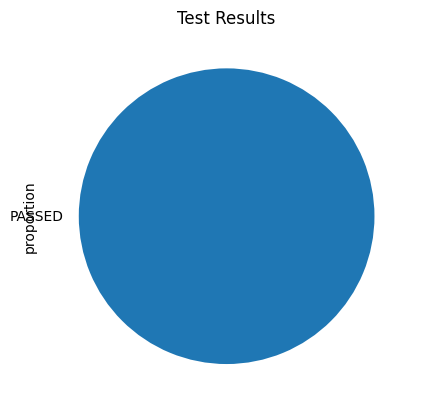

In [26]:
now = datetime.now()

outputPromptEmbeddings.to_csv(f"{MSG_TESTRESULT_FOLDER}\\test_embeddings_{now.strftime('%Y%m%d%H%M%S')}.csv", mode='wb', index=False, quoting=csv.QUOTE_NONNUMERIC)


outputPromptEmbeddings.testresult_categoria_mail.value_counts(normalize=True).plot(kind='pie', title='Test Results')
row_count = len(outputPromptEmbeddings)
print(f"Number of tests: {row_count}")
outputPromptEmbeddings.testresult_categoria_mail.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'